<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeles" data-toc-modified-id="Modeles-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeles</a></span></li><li><span><a href="#Sinus" data-toc-modified-id="Sinus-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sinus</a></span></li><li><span><a href="#Sinus-avec-tendence-linéaire-et-bruit" data-toc-modified-id="Sinus-avec-tendence-linéaire-et-bruit-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Sinus avec tendence linéaire et bruit</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#RNN-simple" data-toc-modified-id="RNN-simple-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>RNN simple</a></span></li><li><span><a href="#LSTM" data-toc-modified-id="LSTM-3.0.2"><span class="toc-item-num">3.0.2&nbsp;&nbsp;</span>LSTM</a></span></li><li><span><a href="#GRU" data-toc-modified-id="GRU-3.0.3"><span class="toc-item-num">3.0.3&nbsp;&nbsp;</span>GRU</a></span></li></ul></li><li><span><a href="#Scores-TimeSeriesSplit" data-toc-modified-id="Scores-TimeSeriesSplit-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Scores TimeSeriesSplit</a></span><ul class="toc-item"><li><span><a href="#RNN-simple" data-toc-modified-id="RNN-simple-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>RNN simple</a></span></li><li><span><a href="#LSTM" data-toc-modified-id="LSTM-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>LSTM</a></span></li><li><span><a href="#GRU" data-toc-modified-id="GRU-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>GRU</a></span></li></ul></li><li><span><a href="#Temperatures-globales" data-toc-modified-id="Temperatures-globales-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Temperatures globales</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import pandas as pd

# Modeles

In [2]:
from tensorflow.keras import Input
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Input, Dense
from tensorflow.keras.losses import mse

def rnn_model(units=10, input_length=1, cell_type=SimpleRNN):
    model = tf.keras.Sequential()
    model.add(Input(shape=(input_length,1)))
    model.add(cell_type(units))
    model.add(Dense(1))
    return model

# Sinus

In [3]:
size=1000
x=np.arange(size)
def signal(A=0, f=1, p=0, a=0, b=0, n=0, s_bias=1, n_bias=1, mult=False):
    sine = A*np.sin(2*f*x*np.pi+p) #+ A*np.cos(2*f/2*x*np.pi+p)
    linear = a * x + b
    noise = n*np.random.normal(size=x.shape)
    if mult:
        return lambda x: linear*(sine+s_bias)*(noise+n_bias)
    return lambda x: linear+sine+noise



In [4]:
s = signal(A=1, f=(1/50))(x)

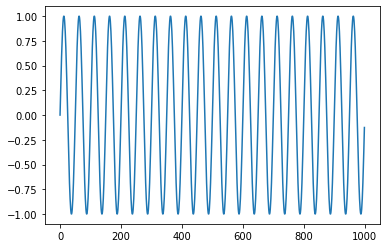

In [5]:
plt.plot(s)

In [6]:
#input_size = 10
X = s[0:-1].reshape(-1,1,1)
y = s[1:]

In [7]:
X.shape

(999, 1, 1)

In [47]:
INPUT_LENGTH = 5
EPOCH = 5
s = s.reshape(-1,1)
train_size = 900
X_train, X_test = s[:train_size], s[train_size-INPUT_LENGTH:]
train_generator = TimeseriesGenerator(X_train, X_train, length=INPUT_LENGTH, batch_size=10)
test_generator = TimeseriesGenerator(X_test, X_test, length=INPUT_LENGTH, batch_size=10)
# X = []
# y = []
# for i in range(len(s)-INPUT_LENGTH):
#     X.append(s[i:i+INPUT_LENGTH])
#     y.append(s[i+INPUT_LENGTH])
# X = np.array(X).reshape(-1,INPUT_LENGTH,1)
# y = np.array(y)
    
simple = rnn_model(units=10, input_length=INPUT_LENGTH, cell_type=SimpleRNN)
simple.compile(optimizer='adam', loss=mse)
simple.summary()
#simple.fit(X, y, batch_size=64, epochs=20, verbose=0)
simple.fit_generator(train_generator, epochs=EPOCH, verbose=0)
#pred = simple.predict(X)
score = simple.evaluate_generator(test_generator)
print(score)
trainPredict = simple.predict_generator(train_generator)
testPredict = simple.predict_generator(test_generator)

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_23 (SimpleRNN)    (None, 10)                120       
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
0.0009677401627413929


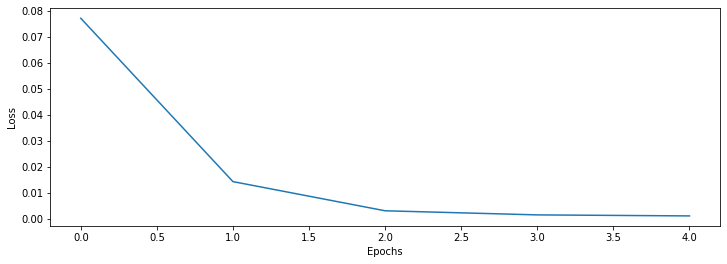

In [48]:
losses = simple.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(len(losses)),losses);

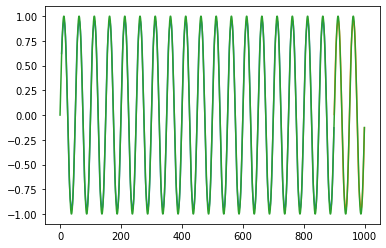

In [49]:
#%matplotlib inline
plt.plot(np.arange(trainPredict.shape[0])+INPUT_LENGTH, trainPredict)
plt.plot(range(train_size, s.shape[0]) ,testPredict)
plt.plot(s)
plt.show()

# Sinus avec tendence linéaire et bruit

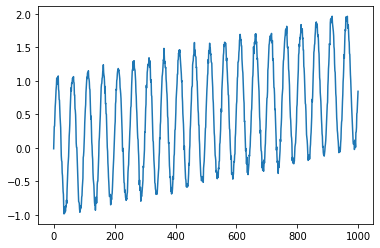

In [11]:
size=1000
x=np.arange(size)
s2 = signal(A=1, f=1/50, a=0.001, n=0.05)(x)
s2 = s2.reshape(-1,1)
# X = []
# y = []
# for i in range(len(s)-INPUT_LENGTH):
#     X.append(s2[i:i+INPUT_LENGTH])
#     y.append(s2[i+INPUT_LENGTH])
# X = np.array(X).reshape(-1,INPUT_LENGTH,1)
# y = np.array(y)

plt.plot(s2);

In [68]:
#from time import time
INPUT_LENGTH = 10
EPOCH = 5
def plot_pred(series, train_size, input_length=INPUT_LENGTH, model=SimpleRNN):
    #train_size = 900
    X_train, X_test = series[:train_size], series[train_size-input_length:]
    train_generator = TimeseriesGenerator(X_train, X_train, length=input_length, batch_size=10)
    test_generator = TimeseriesGenerator(X_test, X_test, length=input_length, batch_size=10)
 
    model = rnn_model(input_length=input_length, cell_type=SimpleRNN)
    model.compile(optimizer='adam', loss=mse)
    
    #start = time()
    model.fit_generator(train_generator, epochs=EPOCH, verbose=0)
    #print(f"fit: {time()-start} s")
    
    
    score = model.evaluate_generator(test_generator)
    print(score)
    
    #start = time()
    trainPredict = model.predict_generator(train_generator)
    #print(f"predict train: {time()-start} s")
    #start = time()
    testPredict = model.predict_generator(test_generator)
    #print(f"predict test: {time()-start} s")
    
    plt.figure(figsize=(12,6))
    losses = model.history.history['loss']
    plt.subplot(2,1,1)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(range(len(losses)),losses)
    
    plt.subplot(2,1,2)
    plt.plot(series)
    plt.plot(np.arange(trainPredict.shape[0])+input_length, trainPredict)
    plt.plot(range(train_size, train_size+testPredict.shape[0]) ,testPredict)
    
    
    

### RNN simple

0.08532687090337276


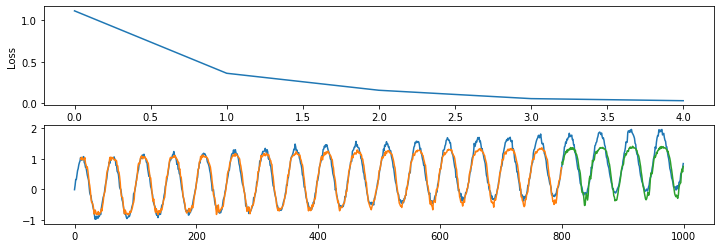

In [69]:
plot_pred(s2, train_size=800, model=SimpleRNN)

### LSTM

0.10783501621335745


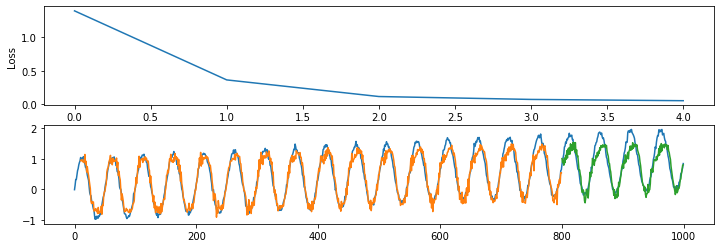

In [70]:
plot_pred(s2, train_size=800, model=LSTM)

### GRU

0.026173204457154497


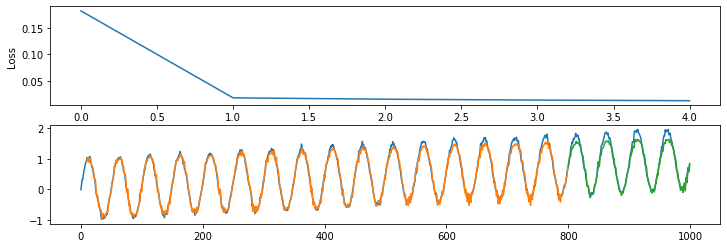

In [71]:
plot_pred(s2, train_size=800, model=GRU)

## Scores TimeSeriesSplit

In [20]:
def score(series, model_type=SimpleRNN):
    scores = [] 
    splits = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in splits.split(X):
        X_train, X_test = series[train_index], series[test_index-INPUT_LENGTH]
        train_generator = TimeseriesGenerator(X_train, X_train, length=INPUT_LENGTH, batch_size=10)
        test_generator = TimeseriesGenerator(X_test, X_test, length=INPUT_LENGTH, batch_size=10)
    
        model = rnn_model(input_length=INPUT_LENGTH, cell_type=model_type)
        model.compile(optimizer='nadam', loss=mse)
    
        model.fit_generator(train_generator, epochs=EPOCH, verbose=0)
    
        scores.append(model.evaluate_generator(test_generator))
    return scores

### RNN simple

In [24]:
rnn_scores = score(s2, SimpleRNN)
print(rnn_scores)

[0.5548876857056337, 0.21513847250710516, 0.20308424828245358, 0.026436921866501078, 0.2529426588512519]


### LSTM

In [25]:
lstm_scores = score(s2, LSTM)
print(lstm_scores)

[0.5178221271318548, 0.2789988573640585, 0.49350621573188724, 0.4989350464414148, 0.12678219416343114]


### GRU

In [26]:
gru_scores = score(s2, GRU)
print(gru_scores)

[0.40946455738123727, 0.43032018215778994, 0.07583773875718608, 0.6291417860809494, 0.0812789847909966]


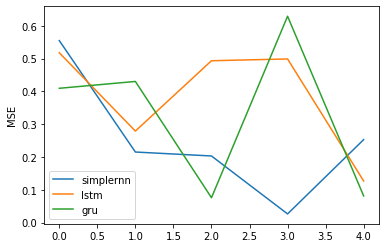

In [27]:
plt.plot(rnn_scores, label='simplernn')
plt.plot(lstm_scores, label='lstm')
plt.plot(gru_scores, label='gru')
plt.ylabel('MSE')
plt.legend()
plt.show()

## Temperatures globales

In [ ]:
temp = pd.read_csv("GlobalLandTemperatures_GlobalTemperatures.csv")
temp["dt"] = temp["dt"].apply(lambda x: np.datetime64(x))
temp = temp[['dt','LandAverageTemperature']]
temp = temp.iloc[-500:]

In [ ]:
plot_pred(temp['LandAverageTemperature'].values.reshape(-1,1), train_size=400, model=SimpleRNN)